In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file csv
data = pd.read_csv('BNB-USD.csv', index_col='Date', parse_dates=True)
# Đảm bảo rằng dữ liệu có tần số thời gian
data = data.asfreq('D')


In [2]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335


In [3]:
mean=data['Close'].mean()
mean

229.61565653333335

In [4]:
data['Close'].var() # default ddof=1

34010.482237758595

In [5]:
std_dev=data['Close'].std(ddof=1)
std_dev

184.41931091336014

In [6]:
data['Close'].mode()

0         9.386050
1         9.600166
2        10.077175
3        10.119137
4        10.140449
           ...    
1915    651.662720
1916    654.315002
1917    662.228577
1918    672.333923
1919    675.684082
Name: Close, Length: 1920, dtype: float64

In [7]:
standard_error = std_dev / np.sqrt(len(data))
standard_error

4.2087756927835835

In [8]:
min(data.Close)

9.38605

In [9]:
max(data.Close)

675.684082

In [10]:
len(data.Close)

1920

In [11]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [12]:
skew(data.Close,bias=False)

0.3286382562803333

In [13]:
kurtosis(data.Close,bias=False)

-0.8995446627169565

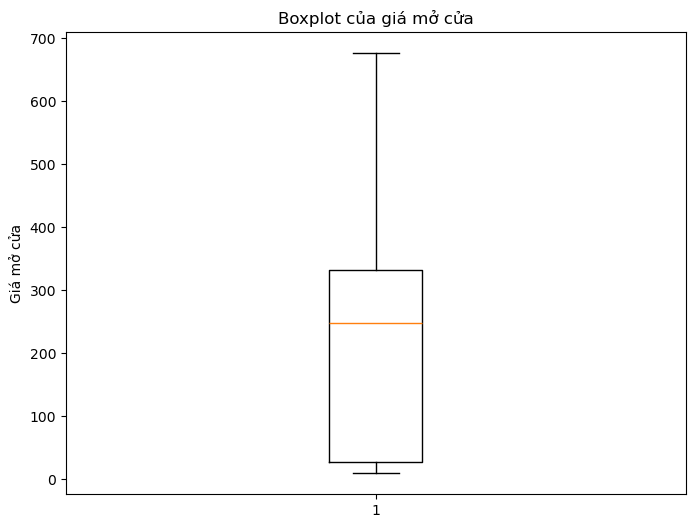

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# Giả sử 'df' là DataFrame chứa dữ liệu của bạn
# Vẽ boxplot cho cột 'Open'
plt.figure(figsize=(8,6))
plt.boxplot(data['Close'])
plt.title('Boxplot của giá mở cửa')
plt.ylabel('Giá mở cửa')
plt.show()


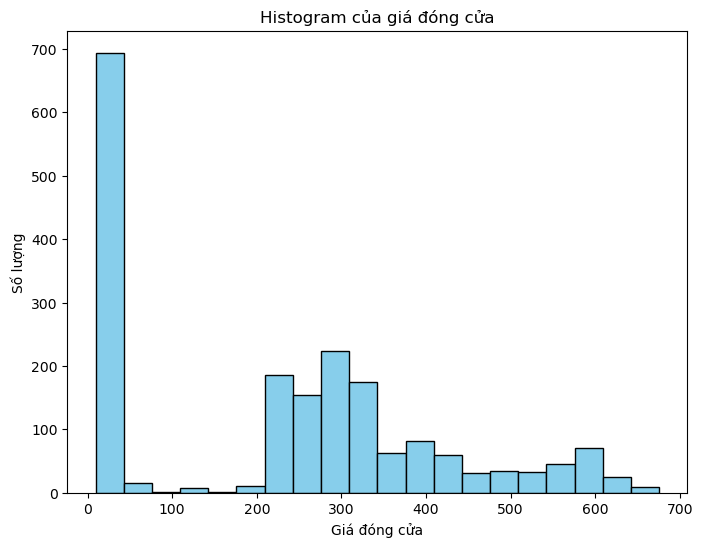

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
# Giả sử 'data' là DataFrame chứa dữ liệu của bạn
# Vẽ histogram cho cột 'Open'
plt.figure(figsize=(8,6))
plt.hist(data['Close'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram của giá đóng cửa')
plt.xlabel('Giá đóng cửa')
plt.ylabel('Số lượng')
plt.show()


In [16]:
# Lấy cột Close
close_values = data['Close']
# Tính IQR
Q1 = close_values.quantile(0.25)
Q3 = close_values.quantile(0.75)
IQR = Q3 - Q1
# Xác định ngưỡng cho outliers
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR
# Tìm outliers
outliers_close = close_values[(close_values < lower_threshold) | (close_values > upper_threshold)]
# In các giá trị outliers
print(outliers_close)

Series([], Freq: D, Name: Close, dtype: float64)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from tbats import TBATS, BATS

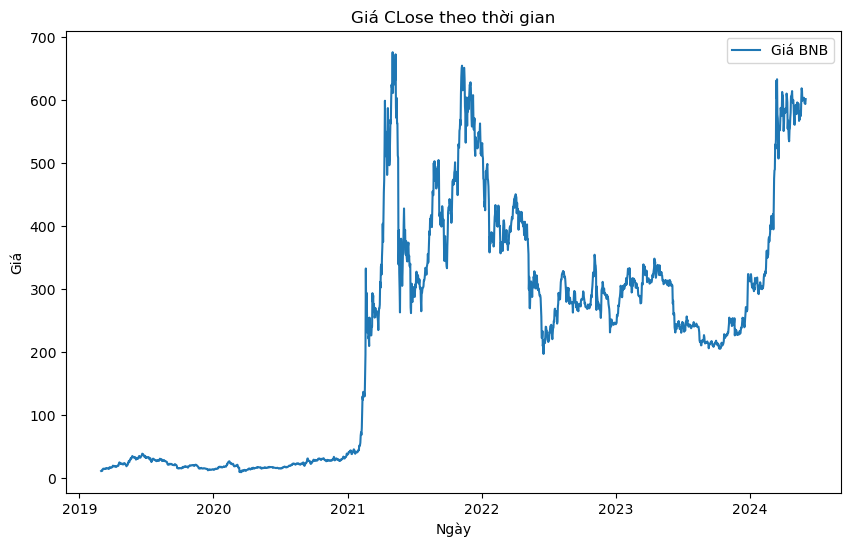

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Giá BNB')
plt.title('Giá CLose theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.legend()
plt.show()


In [19]:
# Chọn các cột 'Close', 'Open', 'High', 'Low', 'Volume' cho model VAR
cols = ['Close', 'Open', 'High', 'Low', 'Volume']
data = data[cols]
# MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Chuyển đổi lại thành DataFrame
data_scaled = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
print(data_scaled.head(10))

               Close      Open      High       Low    Volume
Date                                                        
2019-03-01  0.003012  0.001487  0.002015  0.005357  0.001588
2019-03-02  0.003728  0.003028  0.002468  0.006370  0.001754
2019-03-03  0.003230  0.003718  0.002540  0.006993  0.000025
2019-03-04  0.003242  0.003258  0.002003  0.006544  0.000000
2019-03-05  0.006643  0.003231  0.005297  0.007261  0.008249
2019-03-06  0.007702  0.006575  0.006346  0.009798  0.005678
2019-03-07  0.008645  0.007737  0.007946  0.011920  0.008221
2019-03-08  0.007475  0.008787  0.007472  0.010832  0.007706
2019-03-09  0.007774  0.007376  0.006924  0.011380  0.003980
2019-03-10  0.007667  0.007799  0.006414  0.011329  0.002875


In [20]:
# Hàm để tách dữ liệu và huấn luyện mô hình VAR
def train_and_evaluate(train_size_ratio, data, forecast_horizons):
    train_size = int(len(data) * train_size_ratio)
    test_size = len(data) - train_size

    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]

    # Xác định số lượng lags tối ưu
    best_p = 0
    best_rmse = float('inf')

    for p in range(1, 20):
        model = VAR(train_data)
        results = model.fit(p)

        test_pred = results.forecast(train_data.values[-p:], len(test_data))
        rmse = np.sqrt(mean_squared_error(test_data['Close'], test_pred[:, 0]))
        if rmse < best_rmse:
            best_p = p
            best_rmse = rmse

    # Huấn luyện model VAR trên toàn bộ tập train với số lượng lags tối ưu
    model = VAR(train_data)
    results = model.fit(best_p)

    # Dự đoán giá trị trên tập test
    test_pred = results.forecast(train_data.values[-best_p:], len(test_data))

    
    #Tính toán RMSE, MAPE, MAE, MSE trên tập test
    test_score_rmse = np.sqrt(mean_squared_error(test_data['Close'], test_pred[:, 0]))
    test_score_mape = mean_absolute_percentage_error(test_data['Close'], test_pred[:, 0]) * 100
    test_score_mae = mean_absolute_error(test_data['Close'], test_pred[:, 0])
    test_score_mse = mean_squared_error(test_data['Close'], test_pred[:, 0])

    print(f'RMSE trên tập test là: {test_score_rmse}')
    print(f'MAPE trên tập test là: {test_score_mape} %')
    print(f'MAE trên tập test là: {test_score_mae}')
    print(f'MSE trên tập test là: {test_score_mse}')
    
    # Dự báo tương lai 30, 60, 90 ngày
    forecasts = {}
    forecast_errors = {}
    for horizon in forecast_horizons:
        forecast = results.forecast(data.values[-best_p:], horizon)
        forecasts[horizon] = forecast

        # Tính toán lỗi dự đoán cho mỗi khoảng thời gian dự báo
        if horizon <= len(test_data):
            true_values = test_data['Close'].values[:horizon]
            predicted_values = forecast[:, 0]

            rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
            mape = mean_absolute_percentage_error(true_values, predicted_values) * 100
            mae = mean_absolute_error(true_values, predicted_values)
            mse = mean_squared_error(true_values, predicted_values)

            forecast_errors[horizon] = {
                'RMSE': rmse,
                'MAPE': mape,
                'MAE': mae,
                'MSE': mse
            }

            print(f'\nSai số dự đoán cho {horizon} ngày:')
            print(f'RMSE: {rmse}')
            print(f'MAPE: {mape} %')
            print(f'MAE: {mae} %')
            print(f'MSE: {mse}')
    
    return train_data, test_data, test_pred, forecasts, forecast_errors


In [21]:
# Tạo các bộ dữ liệu và huấn luyện mô hình
ratios = [0.6, 0.7, 0.8]
forecast_horizons = [30, 60, 90]
results = []

for ratio in ratios:
    print(f'\n-----\nTỷ lệ train:test = {ratio}:{1-ratio:.1f}')
    results.append(train_and_evaluate(ratio, data_scaled, forecast_horizons))


-----
Tỷ lệ train:test = 0.6:0.4
RMSE trên tập test là: 0.17125643466798268
MAPE trên tập test là: 24.145671835554015 %
MAE trên tập test là: 0.11731255157062397
MSE trên tập test là: 0.029328766415189025

Sai số dự đoán cho 30 ngày:
RMSE: 0.3484842879298123
MAPE: 72.23698414978661 %
MAE: 0.34597578414237146 %
MSE: 0.12144129893394832

Sai số dự đoán cho 60 ngày:
RMSE: 0.36958703298074047
MAPE: 88.69862736985031 %
MAE: 0.366157395502534 %
MSE: 0.13659457494750696

Sai số dự đoán cho 90 ngày:
RMSE: 0.37682205961927756
MAPE: 97.1411923283863 %
MAE: 0.37397694818003135 %
MSE: 0.14199486461571437

-----
Tỷ lệ train:test = 0.7:0.3
RMSE trên tập test là: 0.18072751925540614
MAPE trên tập test là: 24.238076365993997 %
MAE trên tập test là: 0.12283880135462037
MSE trên tập test là: 0.0326624362162132

Sai số dự đoán cho 30 ngày:
RMSE: 0.4387911677256234
MAPE: 103.64782988192236 %
MAE: 0.4373499823269204 %
MSE: 0.19253768887401612

Sai số dự đoán cho 60 ngày:
RMSE: 0.4499476309048779
MAPE: 113

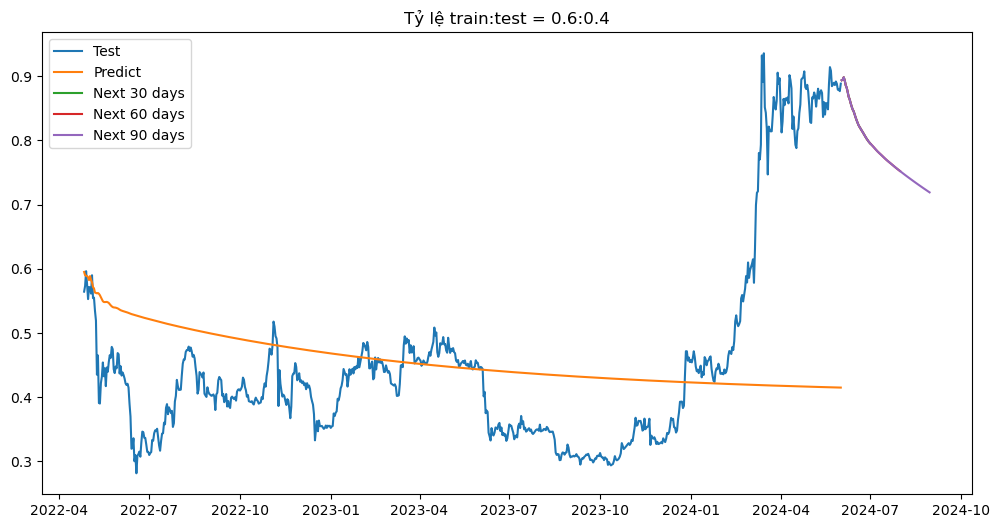

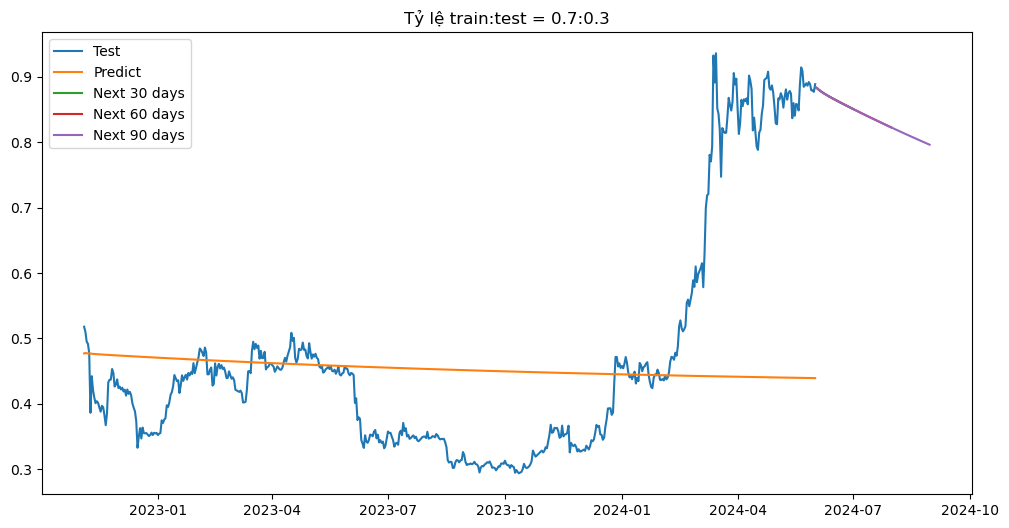

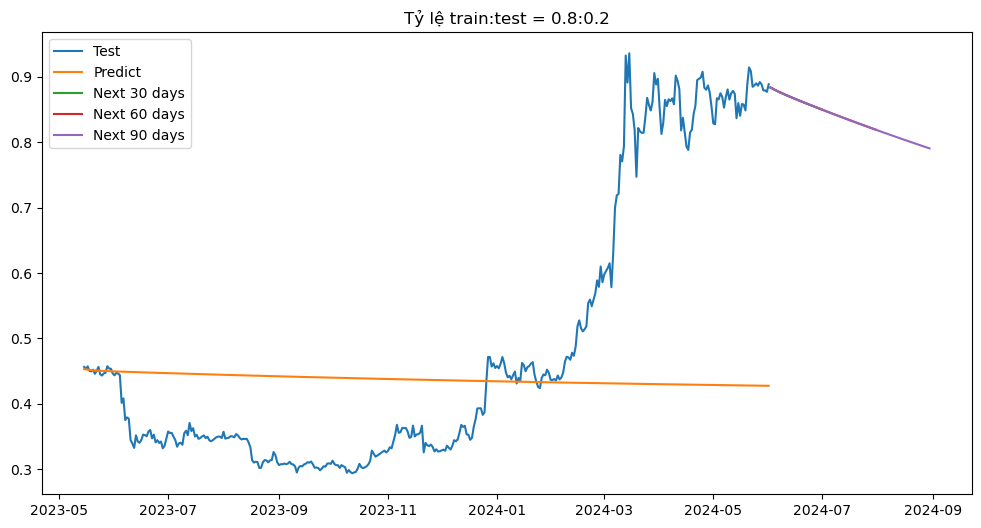

In [23]:
# Vẽ đồ thị cho từng bộ dữ liệu
for i, ratio in enumerate(ratios):
    train_data, test_data, test_pred, forecasts, forecast_errors = results[i]
    
    plt.figure(figsize=(12, 6))
    #plt.plot(train_data.index, train_data['Close'], label='Train')
    plt.plot(test_data.index, test_data['Close'], label='Test')
    plt.plot(test_data.index, test_pred[:, 0], label='Predict')
    #plt.plot(train_data.index, scaler.inverse_transform(train_data)[:, 0], label='Train')
    #plt.plot(test_data.index, scaler.inverse_transform(test_data)[:, 0], label='Test')
    #plt.plot(test_data.index, scaler.inverse_transform(test_pred)[:, 0], label='Predict')
    for horizon in forecast_horizons:
        next_days_df = pd.DataFrame(forecasts[horizon][:, 0], columns=['Close'])
        #next_days_df = pd.DataFrame(scaler.inverse_transform(forecasts[horizon])[:, 0], columns=['Close'])        
        next_days_index = pd.date_range(start=data.index[-1], periods=horizon + 1)[1:]  # Adjusted to not include the starting date
        next_days_df.index = next_days_index
        plt.plot(next_days_df.index, next_days_df['Close'], label=f'Next {horizon} days')

    plt.title(f'Tỷ lệ train:test = {ratio}:{1-ratio:.1f}')
    plt.legend()
    plt.show()

In [24]:
for horizon in forecast_horizons:
    plt.figure(figsize=(12, 6))
    
    for i, ratio in enumerate(ratios):    # In ra giá trị đã dự đoán
        train_data, test_data, test_pred, forecasts, forecast_errors = results[i]
        next_days_df = pd.DataFrame(forecasts[horizon][:, 0], columns=['Close'])
        next_days_index = pd.date_range(start=data.index[-1], periods=horizon + 1)[1:]  # Adjusted to not include the starting date
        next_days_df.index = next_days_index
        print(f'\n-----\nDự báo cho {horizon} ngày tiếp theo với tỷ lệ train:test = {ratio}:{1-ratio:.1f}')
        print(next_days_df)


-----
Dự báo cho 30 ngày tiếp theo với tỷ lệ train:test = 0.6:0.4
               Close
2024-06-02  0.893716
2024-06-03  0.894671
2024-06-04  0.898224
2024-06-05  0.893325
2024-06-06  0.885898
2024-06-07  0.882009
2024-06-08  0.875250
2024-06-09  0.867807
2024-06-10  0.863895
2024-06-11  0.857987
2024-06-12  0.852816
2024-06-13  0.848255
2024-06-14  0.845370
2024-06-15  0.840744
2024-06-16  0.835841
2024-06-17  0.831519
2024-06-18  0.827523
2024-06-19  0.823735
2024-06-20  0.820969
2024-06-21  0.818465
2024-06-22  0.815863
2024-06-23  0.813449
2024-06-24  0.810831
2024-06-25  0.808195
2024-06-26  0.805581
2024-06-27  0.803079
2024-06-28  0.800828
2024-06-29  0.798604
2024-06-30  0.796675
2024-07-01  0.794903

-----
Dự báo cho 30 ngày tiếp theo với tỷ lệ train:test = 0.7:0.3
               Close
2024-06-02  0.882848
2024-06-03  0.881414
2024-06-04  0.879655
2024-06-05  0.878201
2024-06-06  0.876823
2024-06-07  0.875523
2024-06-08  0.874277
2024-06-09  0.873075
2024-06-10  0.871908
2024-

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

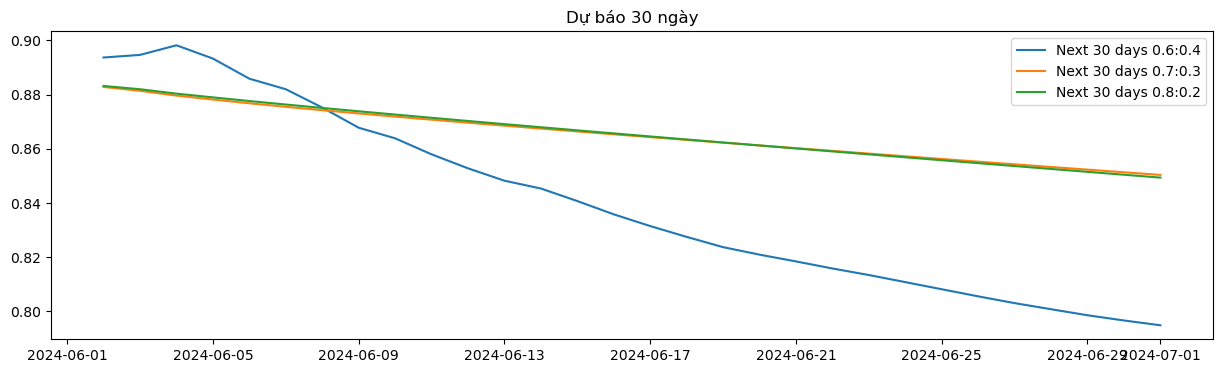

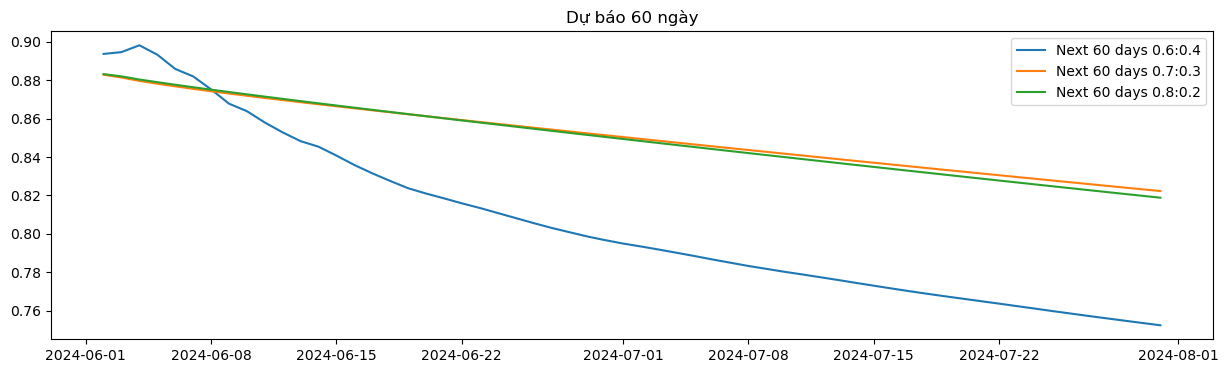

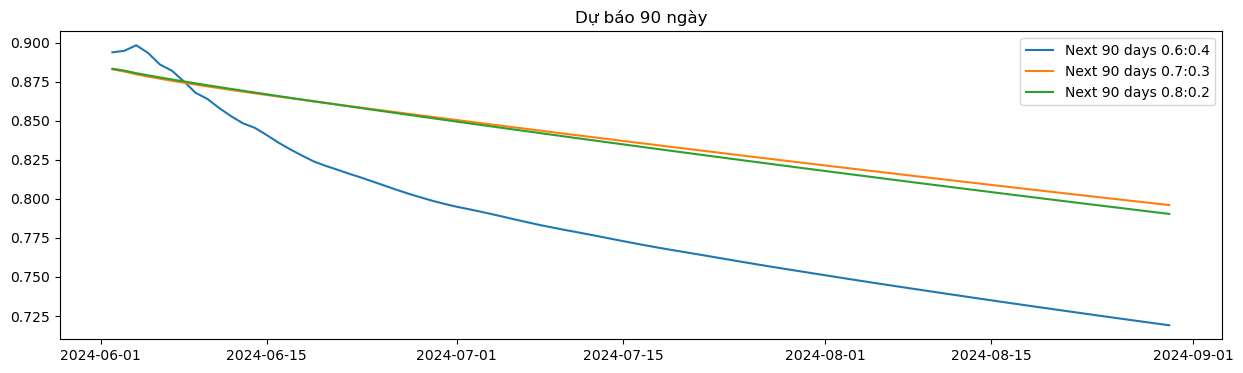

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `data` is your DataFrame and it's already defined.
# Ensure 'data' has a DateTime index and 'Close' column.

for horizon in forecast_horizons:
    plt.figure(figsize=(15, 4))

    for i, ratio in enumerate(ratios):
        train_data, test_data, test_pred, forecasts, forecast_errors = results[i]
        
        # Filter data from May 17 onwards
        train_data_filtered = train_data[train_data.index >= '2024-06-1']
        test_data_filtered = test_data[test_data.index >= '2024-06-1']
        test_pred_filtered = test_pred[test_data.index >= '2024-06-1']
        
        next_days_df = pd.DataFrame(forecasts[horizon][:, 0], columns=['Close'])
        next_days_index = pd.date_range(start=data.index[-1], periods=horizon + 1)[1:]
        next_days_df.index = next_days_index
        next_days_df_filtered = next_days_df[next_days_df.index >= '2024-06-1']

        plt.plot(next_days_df_filtered.index, next_days_df_filtered['Close'], label=f'Next {horizon} days {ratio}:{1-ratio:.1f}')

    plt.title(f'Dự báo {horizon} ngày')
    plt.legend()
    plt.show()


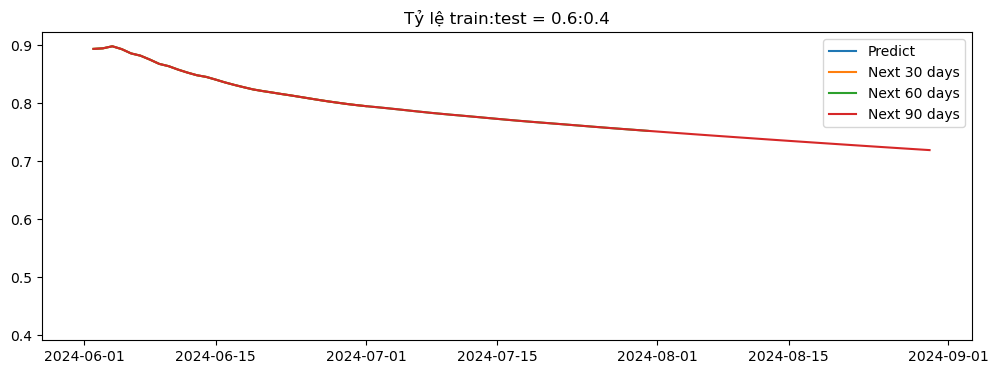

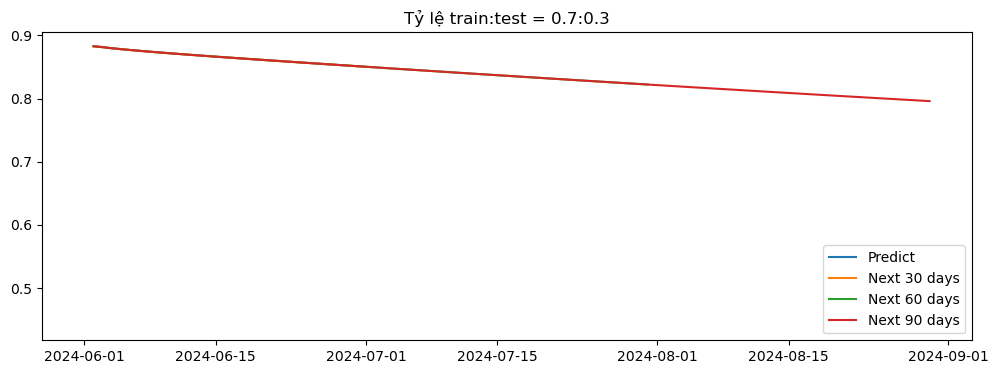

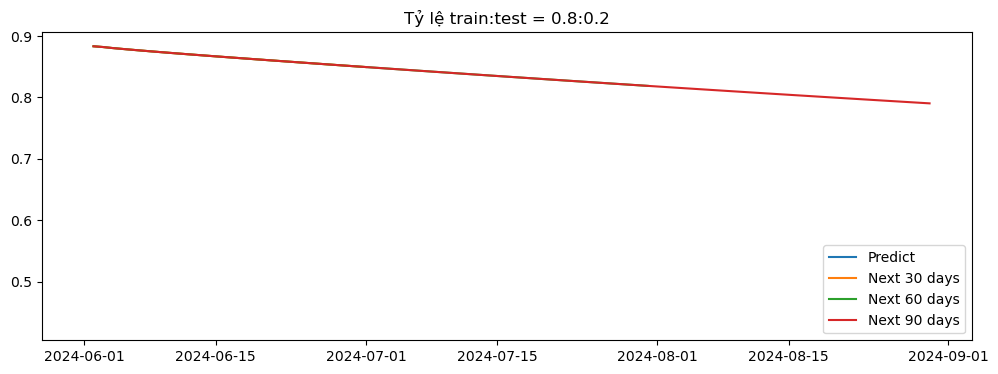

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử `data` là DataFrame của bạn và đã được định nghĩa.
# Đảm bảo 'data' có chỉ số DateTime và cột 'Close'.

# Ngày bắt đầu lọc dữ liệu
start_date = '2024-06-1'

for i, ratio in enumerate(ratios):
    train_data, test_data, test_pred, forecasts, forecast_errors = results[i]
    
    # Lọc dữ liệu từ ngày 17/5/2024 trở đi
    train_data_filtered = train_data[train_data.index >= start_date]
    test_data_filtered = test_data[test_data.index >= start_date]
    test_pred_filtered = test_pred[test_data.index >= start_date]
    
    plt.figure(figsize=(12, 4))
    plt.plot(test_data_filtered.index, test_pred_filtered[:, 0], label='Predict')

    for horizon in forecast_horizons:
        next_days_df = pd.DataFrame(forecasts[horizon][:, 0], columns=['Close'])
        next_days_index = pd.date_range(start=data.index[-1], periods=horizon + 1)[1:]  # Adjusted to not include the starting date
        next_days_df.index = next_days_index
        next_days_df_filtered = next_days_df[next_days_df.index >= start_date]
        plt.plot(next_days_df_filtered.index, next_days_df_filtered['Close'], label=f'Next {horizon} days')

    plt.title(f'Tỷ lệ train:test = {ratio}:{1-ratio:.1f}')
    plt.legend()
    plt.show()
